# Predicting donor-specific cytokine effects on PBMCs

In this tutorial, we predict the donor-specific cytokine effect on PBMCs. The dataset comprises almost ten million cells from 12 different donors, whose samples were treated with 90 different cytokines. More information on the data can be found [here](https://www.parsebiosciences.com/datasets/10-million-human-pbmcs-in-a-single-experiment/). 

## Preliminaries

As the dataset is particularly large, we use [rapids-single-cell](https://rapids-singlecell.readthedocs.io/en/latest/index.html) which allows us to leverage GPU acceleration for preprocessing and downstream tasks. This notebook is executed on a A100 GPU with 80GB memory, as well as 500GB CPU memory. 

In [1]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", SettingWithCopyWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import jax
import functools
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import rapids_singlecell as rsc
import flax.linen as nn
import optax
import cellflow
from cellflow.model import CellFlow
import cellflow.preprocessing as cfpp
from cellflow.utils import match_linear
from cellflow.plotting import plot_condition_embedding
from cellflow.preprocessing import transfer_labels, compute_wknn, centered_pca, project_pca, reconstruct_pca
from cellflow.metrics import compute_r_squared, compute_e_distance


/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
adata = cellflow.datasets.pbmc_cytokines()

Let's investigate the data:

In [3]:
adata.obs.head()

,sample,species,gene_count,tscp_count,mread_count,bc1_wind,bc2_wind,bc3_wind,bc1_well,bc2_well,...,log1p_n_genes_by_counts,log1p_total_counts,total_counts_MT,pct_counts_MT,log1p_total_counts_MT,donor,cytokine,treatment,cell_type,cytokine_family
89_103_005__s1,Donor10_4-1BBL,hg38,2236,4700,8656,89,103,5,H5,p2.A7,...,7.712891,8.455530,56.0,1.191490,4.043051,Donor10,4-1BBL,cytokine,CD8 Naive,TNF
89_103_083__s1,Donor10_4-1BBL,hg38,2222,4337,8235,89,103,83,H5,p2.A7,...,7.706613,8.375169,71.0,1.637076,4.276666,Donor10,4-1BBL,cytokine,B Naive,TNF
89_103_085__s1,Donor10_4-1BBL,hg38,1690,3079,5870,89,103,85,H5,p2.A7,...,7.433075,8.032685,197.0,6.398181,5.288267,Donor10,4-1BBL,cytokine,B Intermediate/Memory,TNF
89_104_009__s1,Donor10_4-1BBL,hg38,1746,3015,5663,89,104,9,H5,p2.A8,...,7.465655,8.011686,84.0,2.786070,4.442651,Donor10,4-1BBL,cytokine,CD14 Mono,TNF
89_104_025__s1,Donor10_4-1BBL,hg38,3182,6986,13153,89,104,25,H5,p2.A8,...,8.065579,8.851807,165.0,2.361867,5.111988,Donor10,4-1BBL,cytokine,CD14 Mono,TNF


We first create a column which saved the experimental condition, i.e. the combination of donor and treatment.
Moreover, we require a boolean column which indicates if a cell is in control or perturbed state.

In [4]:
adata.obs["condition"] = adata.obs.apply(lambda x: x["donor"] + "_" + x["cytokine"], axis=1)
adata.obs["is_control"] = adata.obs.apply(lambda x: True if x["cytokine"]=="PBS" else False, axis=1)

We then normalize the data to a constant library size.

In [5]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Similarly to the use case in the CellFlow manuscript, we aim to predict the response of donors to the IL-15 treatment. As we found performance to increase significantly as soon as the cytokine has been observed for one donor, we include the cytokine treatment for Donor 8, and predict the responses of the remaining donors.

Therefore, we split our training data into training and test data. We note that the test data has to include the control populations ("PBS") of all donors whose response we want to predict. For this notebook, we restrict to predicting the response of donor 1.

In [6]:
adata_train = adata[(adata.obs["cytokine"]!="IL-15") | (adata.obs["donor"]=="Donor8")].copy()
adata_test = adata[((adata.obs["cytokine"]=="IL-15") & (adata.obs["donor"]!="Donor8")) | (adata.obs["cytokine"]=="PBS")].copy()
adata_train.n_obs, adata_test.n_obs

(9593880, 733795)

In [7]:
adata_train.n_obs, adata_test.n_obs

(9593880, 733795)

We now compute PCA on the training data, and then project the test data onto it. CellFlow implements these functions with GPU acceleration, which we can leverage using `method="rapids"`.

In [8]:
cfpp.centered_pca(adata_train, n_comps=100, method="rapids", keep_centered_data=False)
cfpp.project_pca(query_adata=adata_test, ref_adata=adata_train)

## Setting up the CellFlow model

We are now ready to setup the {class}`~cellflow.model.CellFlow` model.

Therefore, we first choose the flow matching solver. We select the solver `"otfm"`, which deterministically maps a cell to its perturbed equivalent. If we wanted to incorporate stochasticity on single-cell level, we would select `"genot"`.

In [9]:
cf = CellFlow(adata_train, solver="otfm")

## Preparing {class}`~cellflow.model.CellFlow`'s data handling with {meth}`~cellflow.model.CellFlow.prepare_data`

We now prepare the data. Therefore, we have to choose the sample representation, i.e. the space the (measure and generated) cells live in. We use {attr}`obsm['X_pca'] <anndata.AnnData.obsm>` as computed above. Moreover, we set the control key to {attr}`obs['is_control'] <anndata.AnnData.obs>`, as defined above.

The `perturbation_covariates` indicates the external intervention, i.e. the cytokine treatment. We define a key (of arbitrary name) `"cytokine_treatment"` for this, and have the values be tuples with the perturbation and potential perturbation covariates. As we don't have a perturbation covariate (e.g. always the same dose), we only have one tuple, and as we don't observe combinations of treatments, the tuple has length 1. We use ESM2 embeddings for representing the cytokines, which we have precomputed already for the purpose of this notebook, saved in {attr}`uns['esm2_embeddings'] <anndata.AnnData.uns>`. Thus, we pass the information that `"esm2_embeddings"` stores embeddings of the {attr}`obs['cytokine'] <anndata.AnnData.obs>` treatments via `perturbation_covariate_reps`.

The sample covariate describes the cellular context independent of the perturbation. In our case, these are donors, and given in the {attr}`obs['donor'] <anndata.AnnData.obs>` column. We use the mean of the control sample as donor representation, precomputed and saved in {attr}`uns['donor_embeddings'] <anndata.AnnData.uns>`. We thus pass this piece of information to {class}`~cellflow.model.CellFlow` via `sample_covariate_reps`. 

It remains to define `split_covariates`, according to which {class}`~cellflow.model.CellFlow` trains and predicts perturbations. In effect, `split_covariates` defines how to split the control distributions, and often coincides with `sample_covariates`. This ensure that we don't learn a mapping from the control distribution of donor A to a perturbed population of donor B, but only within the same donor. 

Finally, we can pass `max_combination_length` and `null_value`. These are relevant for combinations of treatments, which doesn't apply for this use case, as we don't want to predict combinationatorial effects of cytokines. In particular, `max_combination_length` is the maximum number of combinations of cytokines which we train on or we want to eventually predict for. The null value is the token representing no treatment, e.g. relevant when we have a treatment with fewer interventions than `max_combination_length`, see tutorials with combinatorial treatments as examples.

In [10]:
adata.uns.keys()

dict_keys(['donor_embeddings', 'esm2_embeddings', 'hvg', 'log1p'])

In [11]:
cf.prepare_data(
    sample_rep = "X_pca",
    control_key = "is_control",
    perturbation_covariates = {"cytokine_treatment": ("cytokine",)},
    perturbation_covariate_reps = {"cytokine_treatment": "esm2_embeddings"},
    sample_covariates = ["donor"],
    sample_covariate_reps = {"donor": "donor_embeddings"},
    split_covariates = ["donor"],
    max_combination_length = 1,
    null_value = 0.0,
)

100%|██████████| 90/90 [00:42<00:00,  2.14it/s]


We can now prepare the data for validation using {meth}`~cellflow.model.CellFlow.prepare_validation_data`. We can pass arbitrary splits, which we define with the `name` parameter. The corresponding {class}`adata <anndata.AnnData>` object has to contain the true value, such that during evaluation, we can compare the generated with the true cells.

Note that inference takes relatively long due to solving a neural ODE, hence we might not want to evaluate on the full {class}`adata <anndata.AnnData>` objects, but only on a subset of conditions, the number of which we define using `n_conditions_on_log_iteration` and `n_conditions_on_train_end`. The number of cells we generate for each condition corresponds to the number of control cells, in our case to the number of control cells specific to each donor. As in this dataset the number of control cells is relatively large, we now first subsample the {class}`adata <anndata.AnnData>` object to accelerate inference. 

In [12]:
adatas_train_subsampled = []
for cond in adata_train.obs["condition"].unique(): # as we have many conditions, this might take a few minutes
    adatas_train_subsampled.append(sc.pp.subsample(adata_train[adata_train.obs["condition"]==cond], n_obs=1000, copy=True))

adata_train_for_validation = ad.concat(adatas_train_subsampled)

adatas_test_subsampled = []
for cond in adata_test.obs["condition"].unique():
    adatas_test_subsampled.append(sc.pp.subsample(adata_test[adata_test.obs["condition"]==cond], n_obs=2000, copy=True))

adata_test_for_validation = ad.concat(adatas_test_subsampled)


As we require the embeddings for evaluation as well, we need to copy {attr}`adata <anndata.AnnData.uns>` 

In [13]:
adata_train_for_validation.uns = adata_train.uns.copy()
adata_test_for_validation.uns = adata_test.uns.copy()

cf.prepare_validation_data(
    adata_train_for_validation,
    name="train",
    n_conditions_on_log_iteration=10,
    n_conditions_on_train_end=10,
)

cf.prepare_validation_data(
    adata_test_for_validation,
    name="test",
    n_conditions_on_log_iteration=None,
    n_conditions_on_train_end=None,
)

100%|██████████| 2/2 [00:00<00:00, 292.30it/s]


## Preparing {class}`~cellflow.model.CellFlow`'s model architecture with {meth}`~cellflow.model.CellFlow.prepare_model`

We are now ready to specify the architecture of {class}`~cellflow.model.CellFlow`.

We walk through the parameters one by one:

- `encode_conditions` specifies whether we want to process the embeddings. We recommend to always set it to `True`.
- `condition_mode` defines the structure of the learnt condition embedding space. We will use `deterministic` mode with     `regularization=0.0`, which means we learn point estimates of the condition embedding. If we added `regularization>0.0`, this would mean we impose some regularization with respect to the L2-norm of the embeddings. `condition_mode="stochastic"` parameterizes the embeddings space as like a decoder-free variational auto-encoder, i.e. we set a normal isotropic prior on the embeddings, this allows to learn a stochastic mapping and evaluate the uncertainty of predictions on a distributional level (rather than on a single-cell level which can be done with {class}`~cellflow.solvers.GENOT`).
- `regularization`, as mentioned above, is a tradeoff between the flow matching loss (which also implicitly learns the condition embeddings space), and the regularization of the mean and potentially the variance of the embedding space. Here, we learn point-wise estimates without any prior on the embeddings space, thus setting `regularization` to 0.0.
- `pooling` defines how we aggregate combinations of conditions, which doesn't apply here. Putting `"mean"` thus has no effect, while `"attention_token"` or `"attention_seed"` would reduce to self-attention.
- `pooling_kwargs` specifies further keyword arguments for {class}`~cellflow.networks.TokenAttentionPooling` if `pooling` is
  `"attention_token"` or {class}`~cellflow.networks.SeedAttentionPooling` if `pooling` is `"attention_seed"`.
- `layers_before_pool` specifies the layers processing the perturbation variables, i.e. perturbations, perturbation covariates, and sample covariates. It must be a dictionary with keys corresponding to the keys we used in {meth}`~cellflow.model.CellFlow.prepare_data`. In this case, this means that we have keys `"cytokine_treatment"` and `"donor_embeddings"`, with values specifying the architecture, e.g. the type of the module (`"mlp"` or `"self_attention"`) and layer specifications like number of layers, width, and dropout rate.
- `layers_before_pool` specifies the architecture of the module after the pooling has been performed.
- `condition_embedding_dim` is the dimension of the latent space of the condition encoder. We set it to 64.
- `cond_output_dropout` is the dropout applied to the condition embedding, we recommend to set it relatively high, especially if the `condition_embedding_dim` is large.
- `condition_encoder_kwargs` specify the architecture of the {class}`~cellflow.networks.ConditionEncoder`. Here, we don't apply any more specifications.
- `pool_sample_covariates` defines whether the concatenation of the sample covariates should happen before or after pooling, in our case indicating whether it's part of the self-attention or only appended afterwards. 
- `time_freqs` thus (deterministically) embeds the time component before being processed by a feed-forward neural network. This choice is relatively independent of the data. 
- `time_encoder_dims` specifies the architecture how to process the time embedding needed for the neural ODE. Note that we pre-encode the time with a sinusoidal embedding of dimension `time_freqs`. This choice is relatively independent of the data. 
- `time_encoder_dropout` denotes the dropout applied to the layers processing the time component. This choice is relatively independent of the data. 
- `hidden_dims` specifies the layers processing the control cells. The choice depends on the dimensionality of the cell embedding.
- `hidden_dropout` specifies the dropout in the layers defined by `hidden_dims`.
- `decoder_dims` specifies the layers processing the embedding of the condition, the embedding of the cell, and the embedding of the time. It depends on the dimensionality of the cell representation, i.e. the higher-dimensional the cell representation, the higher `decoder_dims` should be chosen.
- `decoder_dropout` sets the dropout rate of the layers processing `decoder_dims`.
- `vf_act_fn` sets the activation function in the {class}`~cellflow.networks._velocity_field.ConditionalVelocityField` if not specified otherwise.
- `vf_kwargs` provides further keyword arguments when the solver is not `"otfm"`, e.g. it provides keywords for {class}`~cellflow.networks._velocity_field.GENOTConditionalVelocityField`, which we don't require for this use case.
- `probability_path` defines the path between pairs of samples which the {class}`~cellflow.networks._velocity_field.ConditionalVelocityField` is regressed against. Here, we use `{"constant_noise": 0.5}`, which internally applies {class}`~ott.neural.methods.flows.dynamics.ConstantNoiseFlow`. This means that the paths are augmented with random normal noise. Note that the magnitude should depend on the support / variance of the cell embedding. The higher the noise, the more the data is augmented, but the less the marginal distributions are fitted. To maintain convergence on the marginals, one can use `{"bridge"}
- `match_fn` defines how to sample pairs batch-wise. If we have largely heterogeneous populations (e.g. whole embryos), we should choose a small entropic regularisation, while for homoegeneous cell populations like cell lines, a large entropic regularisation parameter is sufficient. Moreover, we can select the hyperparameters `tau_a` and `tau_b` determining the extent of unbalancedness in the learnt coupling, see e.g. [moscot](moscot-tools.org) for an in-depth discussion of optimal transport parameters.
- `optimizer` should be used with gradient averaging to have parameter updates after having seen also multiple conditions, not only multiple cells. We found 20 to be a good value, but we recommend to perform a hyperparameter search. 
- `solver_kwargs` is primarily necessary for using a different {attr}`~cellflow.model.CellFlow.solver` than {class}`~cellflow.solvers.OTFlowMatching`, e.g. when using {class}`~cellflow.solvers.GENOT`. So this doesn't apply here.
- `layer_norm_before_concatenation` determines whether to apply a linear layer before concatenating the condition embedding, the time embedding, and the cell embedding. It can be hyperparameterized over, but we generally found it to not significantly help.
- `linear_projection_before_concatenation` applies linear layers to the embeddings of the condition, the time, and the cell. It can be hyperparameterized over, but we generally found it to not significantly help.
- `seed` sets the seed for solvers.

We start with defining the `layers_before_pool` and `layers_after_pool`. Note how similar the definitions are.

In [14]:
layers_before_pool = {
    "cytokine_treatment": {"layer_type": "mlp", "dims": [1024, 1024], "dropout_rate": 0.5},
    "donor": {"layer_type": "mlp", "dims": [256, 256], "dropout_rate": 0.0},
}

layers_after_pool = {
    "layer_type": "mlp", "dims": [1024, 1024], "dropout_rate": 0.0,
}

We now also explicitly define the `match_fn`:

In [15]:
match_fn = functools.partial(match_linear, epsilon=0.5, tau_a=1.0, tau_b=1.0)

Now we are ready to prepare the model:

In [ ]:
cf.prepare_model(
    encode_conditions=True,
    condition_mode="deterministic",
    regularization=0.0,
    pooling="attention_token",
    pooling_kwargs={},
    layers_before_pool=layers_before_pool,
    layers_after_pool=layers_after_pool,
    condition_embedding_dim=256,
    cond_output_dropout=0.9,
    condition_encoder_kwargs={},
    pool_sample_covariates=True,
    time_freqs=1024,
    time_encoder_dims=[1024, 1024, 1024],
    time_encoder_dropout=0.0,
    hidden_dims=[2048, 2048, 2048],
    hidden_dropout=0.0,
    decoder_dims=[4096, 4096, 4096],
    vf_act_fn=nn.silu,
    vf_kwargs=None,
    probability_path={"constant_noise": 0.5},
    match_fn=match_fn,
    optimizer=optax.MultiSteps(optax.adam(5e-5), 20),
    solver_kwargs={},
    layer_norm_before_concatenation=False,
    linear_projection_before_concatenation=False,
)

## Computing and logging metrics during training 

For computing metrics during training, we provide callbacks. We divide callbacks into two categories: The first one performs computations, thus is an instance of {class}`~cellflow.training.ComputationCallback`; the second one are instances of {class}`~cellflow.training.LoggingCallback` and is used for logging. Users can either provide their own callbacks, or make use of existing ones, including {class}`~cellflow.training.Metrics` for computing metrics in the space which the cells are generated in, e.g. in PCA or VAE-space. For computing metrics in gene space, we can use {class}`~cellflow.training.PCADecodedMetrics` in case cells are PCA-embedded, or {class}`~cellflow.training.VAEDecodedMetrics` in case cells are embedding using {class}`~cellflow.external.CFJaxSCVI`. For computing metrics, we can provide user-defined ones, or metrics provided by CellFlow, which we will do below.

For logging, we recommend using [Weights and Biases](https://wandb.ai), for which we provide a callback: {class}`~cellflow.training.WandbLogger`.

As our cells live in PCA-space, we use the {class}`~cellflow.training.PCADecodedMetrics` callback, which takes as input also an {class}`adata <anndata.AnnData>` object which contains the PCs computed from the training data.

In [17]:
metrics_callback = cellflow.training.Metrics(metrics=["r_squared", "mmd", "e_distance"])
decoded_metrics_callback = cellflow.training.PCADecodedMetrics(ref_adata=adata_train, metrics=["r_squared"])
wandb_callback = cellflow.training.WandbLogger(project="cellflow_tutorials", out_dir="~", config={"name": "100m_pbmc"})

# we don't pass the wandb_callback as it requires a user-specific account, but recommend setting it up
callbacks = [metrics_callback, decoded_metrics_callback]


## Training CellFlow

Finally, we are ready to train our model. It just remains to set the number of iterations (this depends on the number of conditions and cells, but should be between 50k and 1m), the batch size (the more heterogeneous the population, the larger), the callbacks which we have defined above, and the frequency of validation steps (note that inference takes relatively long, so once training behaviour is understood for a dataset, we can increase it).

In [18]:
cf.train(
        num_iterations=500_000,
        batch_size=1024,
        callbacks=callbacks,
        valid_freq=20_000,
    )

100%|██████████| 500000/500000 [3:32:09<00:00, 39.28it/s, loss=4.56]     


We can now investigate some training statistics, stored by the {class}`~cellflow.training.CellFlowTrainer`.

In [19]:
cf.trainer.training_logs.keys()

dict_keys(['loss', 'train_r_squared_mean', 'test_r_squared_mean', 'train_mmd_mean', 'test_mmd_mean', 'train_e_distance_mean', 'test_e_distance_mean', 'pca_decoded_test_r_squared_mean', 'pca_decoded_train_r_squared_mean'])

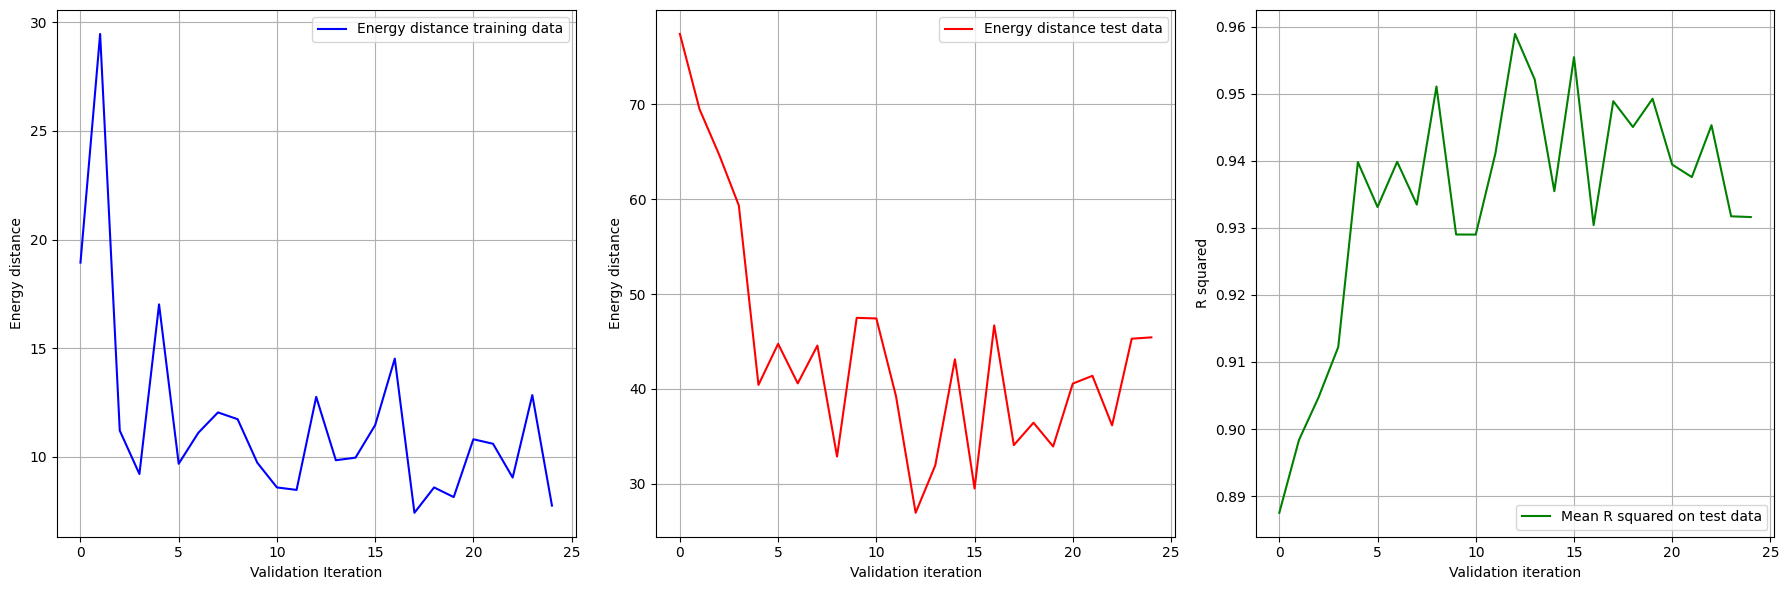

In [20]:
e_distances_train = cf.trainer.training_logs["train_e_distance_mean"]
e_distances_test = cf.trainer.training_logs["test_e_distance_mean"]
r_squared_test   = cf.trainer.training_logs["pca_decoded_test_r_squared_mean"]

iterations_train = np.arange(len(e_distances_train))
iterations_test  = np.arange(len(e_distances_test))
iterations_r2    = np.arange(len(r_squared_test))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(iterations_train, e_distances_train, linestyle='-', color='blue', label='Energy distance training data')
axes[0].set_xlabel('Validation Iteration')
axes[0].set_ylabel('Energy distance')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(iterations_test, e_distances_test, linestyle='-', color='red', label='Energy distance test data')
axes[1].set_xlabel('Validation iteration')
axes[1].set_ylabel('Energy distance')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(iterations_r2, r_squared_test, linestyle='-', color='green', label='Mean R squared on test data')
axes[2].set_xlabel('Validation iteration')
axes[2].set_ylabel('R squared')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


## Investigating the learnt latent space

We can visualize the learnt latent space for any condition using {meth}`~CellFlow.get_condition_embedding`. Therefore, we have to provide a {class}`~pandas.DataFrame` with the same structure of {attr}`adata.obs <anndata.AnnData.obs>` (at least the columns which we used for {meth}`~cellflow.model.CellFlow.prepare_data`). Note that the embedding is independent of the cells, we thus don't need to pass the cellular representation. Moreover, {meth}`~cellflow.model.CellFlow.get_condition_embedding` returns both the learnt mean embedding and the logvariance. The latter is 0 when `condition_mode="stochastic"`, hence we now only visualize the learnt mean. 
For now, let's use all conditions, but indicate whether they're seen during training or not:

In [21]:
covariate_data_train = adata_train[adata_train.obs["cytokine"]!="PBS"].obs.drop_duplicates(subset=["condition"])
covariate_data_test = adata_test[adata_test.obs["cytokine"]!="PBS"].obs.drop_duplicates(subset=["condition"])

df_embedding_train = cf.get_condition_embedding(covariate_data=covariate_data_train, condition_id_key="condition", rep_dict=adata_train.uns)[0]
df_embedding_test = cf.get_condition_embedding(covariate_data=covariate_data_test, condition_id_key="condition", rep_dict=adata_train.uns)[0]

df_embedding_train["seen_during_training"] = True
df_embedding_test["seen_during_training"] = False
df_condition_embedding = pd.concat((df_embedding_train, df_embedding_test))


100%|██████████| 1/1 [00:00<00:00, 843.08it/s]


We can now visualize the embedding, which is 256-dimensional, by calling {meth}`~cellflow.plotting.plot_condition_embedding`. We first visualize it according to whether it was seen during training or not. We choose a kernel PCA representation, but we recommend trying other dimensionaly reduction methods as well. We can see that the unseen conditions integrate well.

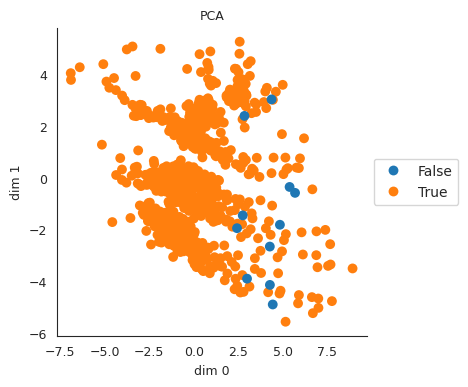

In [22]:
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="seen_during_training", circle_size=50)

Now we can colorize it according to donor and see that the first two principal component captures the variability across donors ...

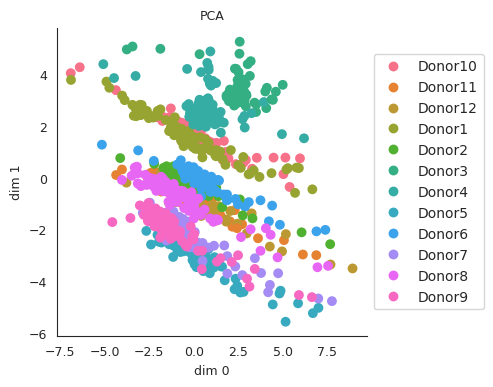

In [23]:
df_condition_embedding["condition"] = df_condition_embedding.index
df_condition_embedding["donor"] = df_condition_embedding.apply(lambda x: x["condition"].split("_")[0], axis=1)
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="donor", circle_size=50)

... and across cytokine treatments.

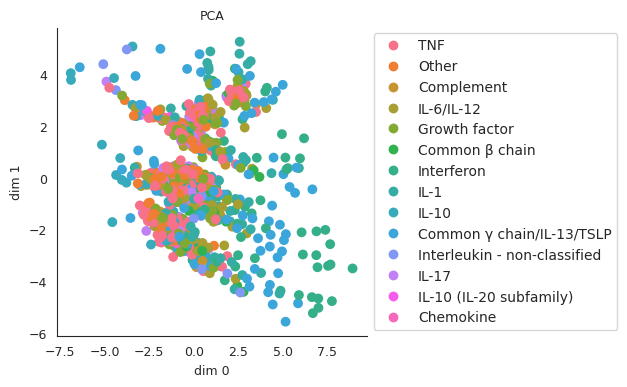

In [24]:
df_cytos = adata.obs.drop_duplicates(subset=["cytokine"])
cyto_to_family = dict(df_cytos.set_index('cytokine')['cytokine_family'])
    
df_condition_embedding["cytokine"] = df_condition_embedding.apply(lambda x: "_".join(x["condition"].split("_")[1:]), axis=1)
df_condition_embedding["cytokine_family"] = df_condition_embedding["cytokine"].map(cyto_to_family)
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="cytokine_family", circle_size=50, legend=False)


## Predicting with CellFlow

Predictions with CellFlow require an {class}`adata <anndata.AnnData>` object with control cells; these can correspond to different sample covariates, i.e. to different donors. Moreover, we require `covariate_data` which are conditions which we would like to predict. In our case, we would like to predict the response to IL-15 from all donors which haven't been seen during training. For the sake of computational speed, we leverage our subsampled data containing 500 control cells per donor. As we only want to make counterfactual predictions for control cells, we have to filter the previously defined `adata_test_for_validation` to control cells only.

In [25]:
adata_ctrl_for_prediction = adata_test_for_validation[adata_test_for_validation.obs["is_control"].to_numpy()]
adata_ctrl_for_prediction.obs["condition"].unique()

array(['Donor10_PBS', 'Donor11_PBS', 'Donor12_PBS', 'Donor1_PBS',
       'Donor2_PBS', 'Donor3_PBS', 'Donor4_PBS', 'Donor5_PBS',
       'Donor6_PBS', 'Donor7_PBS', 'Donor8_PBS', 'Donor9_PBS'],
      dtype=object)

The covariate data is supposed to contain the conditions which we would like to transform the source cells into:

In [26]:
covariate_data_il15 = adata_test_for_validation[~adata_test_for_validation.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])
covariate_data_il15.head()

,sample,species,gene_count,tscp_count,mread_count,bc1_wind,bc2_wind,bc3_wind,bc1_well,bc2_well,...,total_counts_MT,pct_counts_MT,log1p_total_counts_MT,donor,cytokine,treatment,cell_type,cytokine_family,condition,is_control
11_151_069__s141,Donor10_IL-15,hg38,2783,6570,14045,11,151,69,A11,p2.E7,...,90.0,1.369863,4.510859,Donor10,IL-15,cytokine,CD14 Mono,Common γ chain/IL-13/TSLP,Donor10_IL-15,False
11_105_016__s29,Donor11_IL-15,hg38,1811,3352,6614,11,105,16,A11,p2.A9,...,41.0,1.223150,3.737670,Donor11,IL-15,cytokine,CD4 Naive,Common γ chain/IL-13/TSLP,Donor11_IL-15,False
11_192_045__s45,Donor12_IL-15,hg38,732,1047,2236,11,192,45,A11,p2.H12,...,61.0,5.826170,4.127134,Donor12,IL-15,cytokine,B Naive,Common γ chain/IL-13/TSLP,Donor12_IL-15,False
11_002_126__s118,Donor1_IL-15,hg38,2795,7518,13960,11,2,126,A11,A2,...,105.0,1.396648,4.663439,Donor1,IL-15,cytokine,CD4 Naive,Common γ chain/IL-13/TSLP,Donor1_IL-15,False
11_064_074__s56,Donor2_IL-15,hg38,2330,4459,9349,11,64,74,A11,F4,...,43.0,0.964342,3.784190,Donor2,IL-15,cytokine,CD4 Memory,Common γ chain/IL-13/TSLP,Donor2_IL-15,False


Now we can compute the predicted cellular states of IL-15 treatments for all donors which we haven't seen during training. Again, we specify where the cellular data is stored via `sample_rep`, and provide a `condition_id_key` which defines the keys of the returned dictionary containing the predictions.

In [27]:
preds = cf.predict(adata=adata_ctrl_for_prediction, sample_rep="X_pca", condition_id_key="condition", covariate_data=covariate_data_il15)

100%|██████████| 1/1 [00:00<00:00, 882.45it/s]


We now build an {class}`adata <anndata.AnnData>` object to store the predictions in {attr}`adata.obsm <anndata.AnnData.obsm>`:

In [28]:
adata_preds = []
for cond, array in preds.items():
    
    obs_data = pd.DataFrame({
        'condition': [cond] * array.shape[0]
    })
    adata_pred = ad.AnnData(X=np.empty((len(array),adata_train.n_vars)), obs=obs_data)
    adata_pred.obsm["X_pca"] = np.squeeze(array)
    adata_preds.append(adata_pred)

adata_preds = ad.concat(adata_preds)
adata_preds.var_names = adata_train.var_names

We now transfer labels using the 1NN classifier based on the training data. Therefore, we first have to compute a nearest neighbor graph, and then transfer the labels subsequently. Note that for the sake of computational speed, we here use subsampled training data `adata_train_for_validation`.

In [29]:
compute_wknn(ref_adata=adata_train_for_validation, query_adata=adata_preds, n_neighbors=1, ref_rep_key="X_pca", query_rep_key="X_pca")
transfer_labels(query_adata=adata_preds, ref_adata=adata_train_for_validation, label_key="cell_type")

We now reconstruct the cells generated in PCA space to gene space:

In [30]:
reconstruct_pca(query_adata=adata_preds, use_rep="X_pca", ref_adata=adata_train, layers_key_added="X_recon")
adata_preds.layers

Layers with keys: X_recon

Now, we can plot our predictions together with transferred cell types, and compare it to the true cells, and a subset of the training data.

In [31]:
adata_preds.obs["donor"] = adata_preds.obs.apply(lambda x: x["condition"].split("_")[0], axis=1)
adata_preds.obs["cytokine"] = adata_preds.obs.apply(lambda x: "_".join(x["condition"].split("_")[1:]), axis=1)
adata_preds.obs["cell_type"] = adata_preds.obs["cell_type_transfer"]
adata_preds.X = adata_preds.layers["X_recon"]
del adata.layers

adata_preds.obs["mode"] = "generated"
adata_train_for_validation.obs["mode"] = "train"
adata_test_for_validation.obs["mode"] = "test"

adata_concatenated = ad.concat((adata_preds, adata_train_for_validation, adata_test_for_validation[~adata_test_for_validation.obs["is_control"].to_numpy()]))

rsc.pp.pca(adata_concatenated)
rsc.pp.neighbors(adata_concatenated)
rsc.tl.umap(adata_concatenated)


[2025-04-04 14:43:56.716] [CUML] [debug] n_neighbors=15
[2025-04-04 14:43:56.826] [CUML] [debug] Calling knn graph run
[2025-04-04 14:43:56.826] [CUML] [debug] Done. Calling fuzzy simplicial set
[2025-04-04 14:43:57.696] [CUML] [debug] Done. Calling remove zeros


For a visual assessment, we compare true cells with generated cells on a UMAP

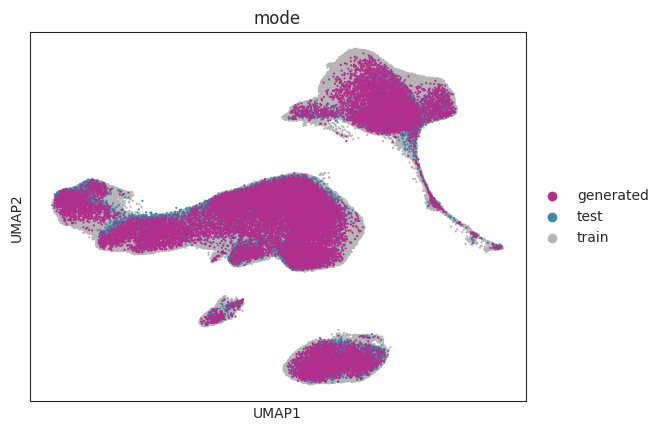

In [32]:
adata_concatenated.obs["condition_mode"] = adata_concatenated.obs.apply(lambda x: x["condition"] + "_" + x["mode"], axis=1)
adata_concatenated.obs.reset_index(inplace=True)

color_palette = {"generated": "#B12F8C", "test": "#3F8AA6", "train": "#B6B6B6"}
order = list(adata_concatenated[adata_concatenated.obs["mode"]=="train"].obs_names) + list(adata_concatenated[adata_concatenated.obs["mode"]=="test"].obs_names) + list(adata_concatenated[adata_concatenated.obs["mode"]=="generated"].obs_names)
sc.pl.umap(adata_concatenated[order], color=["mode"], palette=color_palette, size=10)

We can also compare the true with the predicted population donor-specifically, together with a comparison to the control distribution, hence visualising both the donor effect and the perturbation effect. Qualitatively, the magenta (predicted) distribution should be closer to the blue (true) distribution than to the black (control) distribution.

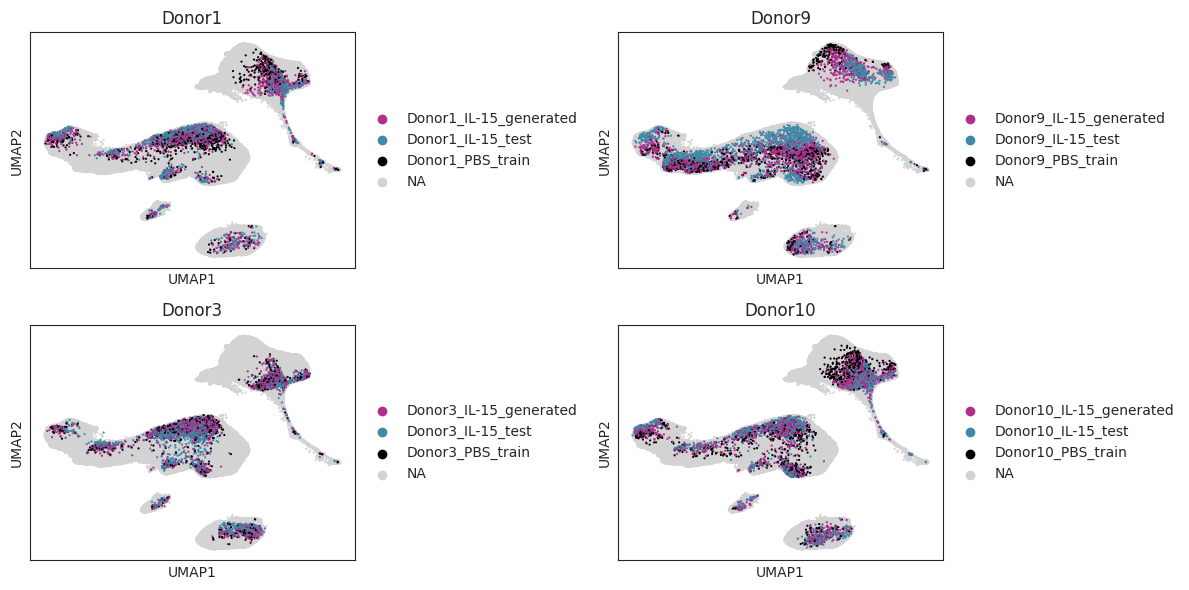

In [33]:
def plot_umap_highlight(adata, donor_id, ax):
    groups_to_visualize = [f"{donor_id}_PBS_train", f"{donor_id}_IL-15_test", f"{donor_id}_IL-15_generated"]
    
    # Define color palette
    color_palette = {k: "#B6B6B6" for k in adata.obs["condition_mode"].unique()}
    color_palette.update({
        f"{donor_id}_IL-15_generated": "#B12F8C",
        f"{donor_id}_IL-15_test": "#3F8AA6",
        f"{donor_id}_PBS_train": "#000000",
    })
    obs_to_highlight = list(adata[adata.obs["condition_mode"].isin(groups_to_visualize)].obs_names)
    np.random.shuffle(obs_to_highlight)
    order = list(adata[~adata.obs["condition_mode"].isin(groups_to_visualize)].obs_names) + \
            obs_to_highlight
    
    sc.pl.umap(
        adata[order],
        color="condition_mode",
        groups=groups_to_visualize,
        palette=color_palette,
        size=10,
        ax=ax,
        show=False,
        title=donor_id
    )

donors = ["Donor1", "Donor9", "Donor3", "Donor10"]
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs = axs.flatten()

for i, donor in enumerate(donors):
    plot_umap_highlight(adata_concatenated, donor, axs[i])

plt.tight_layout()
plt.show()


We can also inspect the predicted gene expression next to the true gene expression, e.g. of the IL-15 treated CD14 differentially expressed gene IDO1.

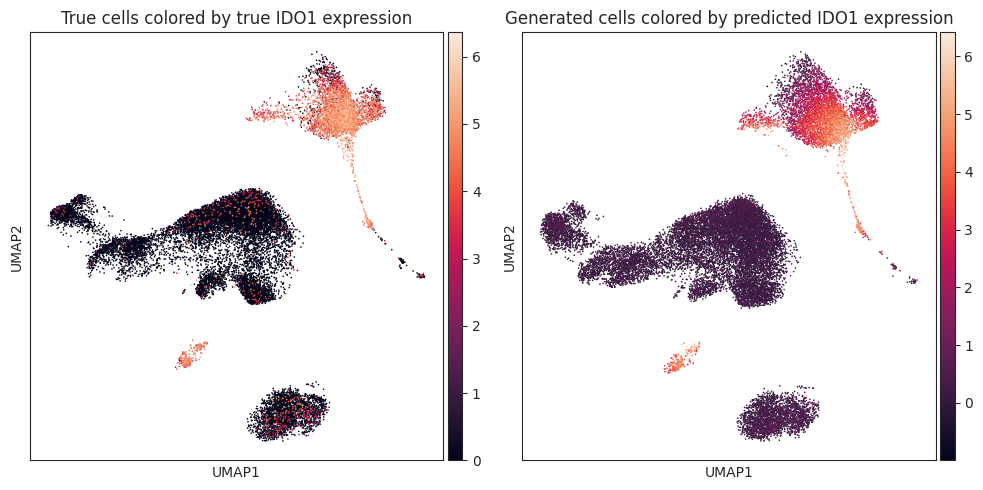

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sc.pl.umap(
    adata_concatenated[adata_concatenated.obs["mode"] == "test"],
    color=["IDO1"],
    ax=axs[0],
    show=False,
    title="True cells colored by true IDO1 expression"
)
sc.pl.umap(
    adata_concatenated[adata_concatenated.obs["mode"] == "generated"],
    color=["IDO1"],
    ax=axs[1],
    show=False,
    title="Generated cells colored by predicted IDO1 expression"
)
plt.tight_layout()
plt.show()


Finally, we compute a few metrics. For evaluation of distributional metrics, we compute a lower-dimensional PCA space from the entire dataset (including the test data). For computational reasons, we subsample the entire dataset first, compute a PCA embedding, and subsequently project both the true and the generated cells onto it.

In [35]:
adata_ref = sc.pp.subsample(adata, n_obs=100_000, copy=True)
cfpp.centered_pca(adata_ref, n_comps=30, method="rapids")
adata_true = adata_test_for_validation[~adata_test_for_validation.obs["is_control"].to_numpy()]
cfpp.project_pca(query_adata=adata_preds, ref_adata=adata_ref)
cfpp.project_pca(query_adata=adata_true, ref_adata=adata_ref)


In [36]:
test_data_target_encoded = {}
test_data_target_decoded = {}
test_data_target_encoded_predicted = {}
test_data_target_decoded_predicted = {}

for cond in adata_preds.obs["condition"].unique():
    test_data_target_encoded[cond] = adata_true[adata_true.obs["condition"] == cond].obsm["X_pca"]
    test_data_target_decoded[cond] = adata_true[adata_true.obs["condition"] == cond].X.toarray()
    test_data_target_encoded_predicted[cond] = adata_preds[adata_preds.obs["condition"] == cond].obsm["X_pca"]
    test_data_target_decoded_predicted[cond] = adata_preds[adata_preds.obs["condition"] == cond].X


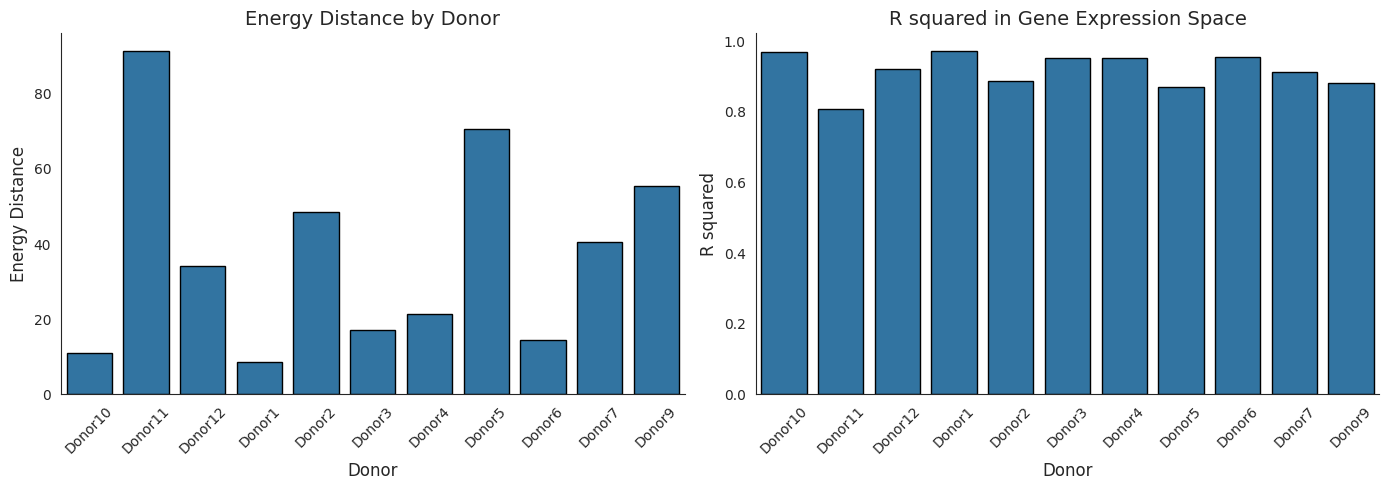

In [37]:
e_distances = jax.tree_util.tree_map(
    compute_e_distance, test_data_target_encoded, test_data_target_encoded_predicted
)

r_squared = jax.tree_util.tree_map(
    compute_r_squared, test_data_target_decoded, test_data_target_decoded_predicted
)

df_e_distance = pd.DataFrame.from_dict(e_distances, orient="index", columns=["energy_distance"])
df_r_squared = pd.DataFrame.from_dict(r_squared, orient="index", columns=["r_squared"])
df_metrics = pd.merge(df_e_distance, df_r_squared, left_index=True, right_index=True)
df_metrics["condition"] = df_metrics.index
df_metrics["donor"] = df_metrics.apply(lambda x: x["condition"].split("_")[0], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

sns.barplot(
    data=df_metrics,
    x="donor",
    y="energy_distance",
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title("Energy Distance by Donor", fontsize=14)
axes[0].set_xlabel("Donor", fontsize=12)
axes[0].set_ylabel("Energy Distance", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(
    data=df_metrics,
    x="donor",
    y="r_squared",
    edgecolor="black",
    ax=axes[1]
)
axes[1].set_title("R squared in Gene Expression Space", fontsize=14)
axes[1].set_xlabel("Donor", fontsize=12)
axes[1].set_ylabel("R squared", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

sns.despine()
plt.tight_layout()
plt.show()
